# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Watermark" data-toc-modified-id="Watermark-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Watermark</a></div><div class="lev1 toc-item"><a href="#Imports-and-Setups" data-toc-modified-id="Imports-and-Setups-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports and Setups</a></div><div class="lev3 toc-item"><a href="#Autoimport-my-code" data-toc-modified-id="Autoimport-my-code-201"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Autoimport my code</a></div><div class="lev3 toc-item"><a href="#Plotting" data-toc-modified-id="Plotting-202"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>Plotting</a></div><div class="lev1 toc-item"><a href="#ENCODE-RNAseq" data-toc-modified-id="ENCODE-RNAseq-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>ENCODE RNAseq</a></div><div class="lev2 toc-item"><a href="#DESeq2-on-longleaf" data-toc-modified-id="DESeq2-on-longleaf-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>DESeq2 on longleaf</a></div><div class="lev2 toc-item"><a href="#Exploration" data-toc-modified-id="Exploration-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Exploration</a></div><div class="lev2 toc-item"><a href="#Nearby" data-toc-modified-id="Nearby-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Nearby</a></div><div class="lev2 toc-item"><a href="#Correlations" data-toc-modified-id="Correlations-34"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Correlations</a></div><div class="lev3 toc-item"><a href="#Xist-similarity" data-toc-modified-id="Xist-similarity-341"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>Xist similarity</a></div>

# Watermark

In [3]:
%load_ext watermark
%watermark -a 'Jessime Kirk' -nmv --packages numpy,scipy,pandas,sklearn,matplotlib,seaborn,networkx,notebook,jupyter_contrib_nbextensions

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Jessime Kirk Wed Sep 06 2017 

CPython 3.6.2
IPython 6.1.0

numpy 1.13.1
scipy 0.19.1
pandas 0.20.3
sklearn 0.19.0
matplotlib 2.0.2
seaborn 0.8.0
networkx 1.11
notebook 5.0.0
jupyter_contrib_nbextensions 0.2.8

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 4.10.0-33-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


# Imports and Setups

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from tqdm import tqdm, trange, tqdm_notebook, tnrange

from scipy.stats import describe
from scipy.stats import pearsonr

from numpy.polynomial.polynomial import polyfit

### Autoimport my code

In [2]:
pwd

'/home/jessime/Code/kmers3/Notebooks'

In [3]:
cd ..

/home/jessime/Code/kmers3


In [4]:
%load_ext autoreload

In [5]:
autoreload 2

### Plotting

In [6]:
%matplotlib inline
plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
#plt.rcParams['font.family'] = 'sans-serif'
#plt.rcParams['font.sans-serif'] = 'Helvetica'
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

# ENCODE RNAseq

I'm working on my ENCODE RNAseq pipeline to find RNA in-cis correlations. 

Joel Parker has recommended that we use DESeq2 to normalize counts across experiments. One of the files that I need is a two column csv files that create key value pairs between transcript names (as seen in the Salmon `quant.sf` file) and gene names. I've got a similar value, so this is a quick fix.

In [8]:
id2name = pd.read_csv('/home/jessime/Research/v26_full_unspliced_id2name.csv', index_col=0)
id2name.head()

gene_id       common  unspliced
UNSPLICED0         ENSG00000223972.5   DDX11L1-un       True
ENST00000456328.2  ENSG00000223972.5  DDX11L1-002      False
ENST00000450305.2  ENSG00000223972.5  DDX11L1-001      False
UNSPLICED1         ENSG00000227232.5    WASH7P-un       True
ENST00000488147.1  ENSG00000227232.5   WASH7P-001      False

In [9]:
def tx2common_gene(common):
    return common if common.endswith('-un') else common[:common.rindex('-')]

genes = id2name['common'].apply(tx2common_gene)
genes.head()

UNSPLICED0           DDX11L1-un
ENST00000456328.2       DDX11L1
ENST00000450305.2       DDX11L1
UNSPLICED1            WASH7P-un
ENST00000488147.1        WASH7P
Name: common, dtype: object

In [17]:
tx2gene = pd.DataFrame.from_dict({'TXNAME':id2name.index.values, 'GENEID':genes.values})
tx2gene = tx2gene[tx2gene.columns[::-1]]
#tx2gene.index = [i+1 for i in tx2gene.index]
tx2gene.head()

TXNAME      GENEID
0         UNSPLICED0  DDX11L1-un
1  ENST00000456328.2     DDX11L1
2  ENST00000450305.2     DDX11L1
3         UNSPLICED1   WASH7P-un
4  ENST00000488147.1      WASH7P

**Note: ** This is set up for an R dataframe.

In [18]:
tx2gene.to_csv('/home/jessime/Research/v26_full_unspliced_tx2gene.csv', index=False)

## DESeq2 on longleaf

```bash
srun -n 8 --time=8:00:00 --mem=32g --pty bash
module load r
cd ~/submissions/encode_rnaseq/
Rscript deseq2_encode_rnaseq.r /pine/scr/j/e/jessime/encode_rnaseq/experiments/ /pine/scr/j/e/jessime/encode_rnaseq/v26_full_unspliced_tx2gene.csv
```

## Exploration

I've gotten my normalized counts and have lab meeting tomorrow. I don't have time to do any correlations because I don't have the code to find nearby genes ready to go. Insetead, I'm just going to get a sense for these numbers what this matrix is like.

In [19]:
df = pd.read_csv('/home/jessime/Research/encode_rnaseq/salmon_norm_counts.csv', index_col=0)
print(df.shape)
df.head()

(93228, 140)


1         2         3         4         5         6  \
5_8S_rRNA.1  0.755728  0.755728  0.755728  0.755728  0.755728  0.755728   
5_8S_rRNA.2  0.755728  0.755728  0.755728  0.755728  0.755728  0.755728   
5_8S_rRNA.4  0.755728  0.755728  0.755728  0.755728  0.755728  0.755728   
5_8S_rRNA.5  0.755728  0.755728  0.755728  0.755728  0.755728  0.755728   
5_8S_rRNA.6  0.755728  0.755728  0.755728  0.755728  0.755728  0.755728   

                    7         8         9        10    ...          131  \
5_8S_rRNA.1  0.755728  0.755728  0.755728  0.755728    ...     0.755728   
5_8S_rRNA.2  0.755728  0.755728  0.755728  0.755728    ...     0.755728   
5_8S_rRNA.4  0.755728  0.755728  0.755728  0.755728    ...     0.755728   
5_8S_rRNA.5  0.755728  0.755728  0.755728  0.755728    ...     0.755728   
5_8S_rRNA.6  0.755728  0.755728  0.755728  0.755728    ...     0.755728   

                  132       133       134       135       136       137  \
5_8S_rRNA.1  0.755728  0.755728  0.755728  0.755728  0.755728  0.755728   
5_8S_rRNA.2  0.755728  0.755728  0.755728  0.755728  0.755728  0.755728   
5_8S_rRNA.4  0.755728  0.755728  0.755728  0.755728  0.755728  0.755728   
5_8S_rRNA.5  0.755728  0.755728  0.755728  0.755728  0.755728  0.755728   
5_8S_rRNA.6  0.755728  0.755728  0.755728  0.755728  0.755728  0.755728   

                  138       139       140  
5_8S_rRNA.1  0.755728  0.755728  0.755728  
5_8S_rRNA.2  0.755728  0.755728  0.755728  
5_8S_rRNA.4  0.755728  0.755728  0.755728  
5_8S_rRNA.5  0.755728  0.755728  0.755728  
5_8S_rRNA.6  0.755728  0.755728  0.755728  

[5 rows x 140 columns]

Let's start simple and look at the distributions of a couple of these:

1
DescribeResult(nobs=93228, minmax=(0.7557279309253041, 23.556681103030499), mean=4.2592172659733638, variance=16.339417812823697, skewness=0.8614388190158658, kurtosis=-0.5885005372476289)


10
DescribeResult(nobs=93228, minmax=(0.7557279309253041, 23.750926408938199), mean=4.1166304901964539, variance=16.511884756934727, skewness=0.9522686616728617, kurtosis=-0.4082067828318521)


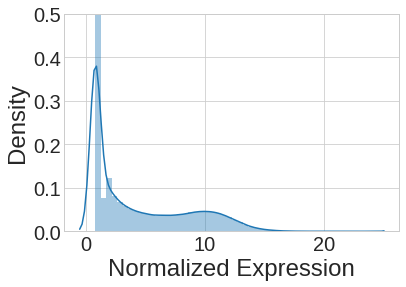

20
DescribeResult(nobs=93228, minmax=(0.7557279309253041, 24.261563234634398), mean=4.0314682346457964, variance=16.69914041040127, skewness=0.9395414108708522, kurtosis=-0.48144714082463125)


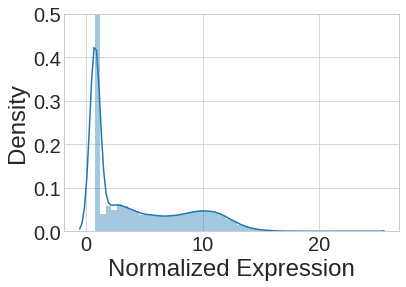

In [20]:
for i in [1, 10, 20]:
    print(i)
    print(describe(df[str(i)]))
    sns.distplot(df[str(i)])
    plt.ylim([0, .5])
    plt.ylabel('Density')
    plt.xlabel('Normalized Expression')
    plt.show()

What's the distribution of means for each gene?

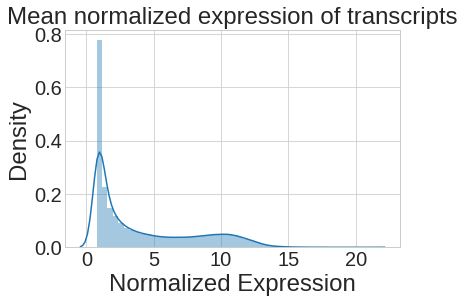

In [21]:
means = df.mean(axis=1)
sns.distplot(means)
plt.title('Mean normalized expression of transcripts')
plt.ylabel('Density')
plt.xlabel('Normalized Expression')
plt.show()

What's the difference in expression between spliced and unspliced?

In [22]:
id2name.head()

gene_id       common  unspliced
UNSPLICED0         ENSG00000223972.5   DDX11L1-un       True
ENST00000456328.2  ENSG00000223972.5  DDX11L1-002      False
ENST00000450305.2  ENSG00000223972.5  DDX11L1-001      False
UNSPLICED1         ENSG00000227232.5    WASH7P-un       True
ENST00000488147.1  ENSG00000227232.5   WASH7P-001      False

In [23]:
reversed_dict = {v:k for k, v in genes.to_dict().items()}
spliced = [reversed_dict[i] for i in df.index.values]
spliced = np.array([not id2name.loc[i].unspliced for i in spliced])

In [24]:
print(sum(spliced))
print(len(spliced)-sum(spliced))

35349
57879


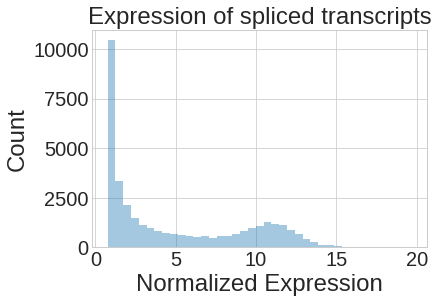

In [25]:
sns.distplot(df.loc[spliced].mean(axis=1), kde=False)
plt.title('Expression of spliced transcripts')
plt.ylabel('Count')
plt.xlabel('Normalized Expression')
plt.show()

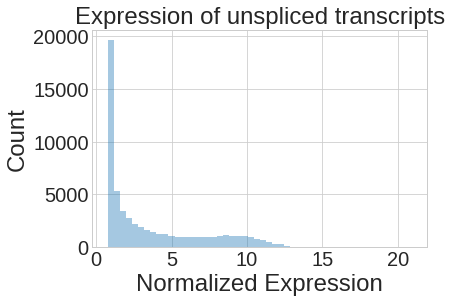

In [26]:
sns.distplot(df.loc[~spliced].mean(axis=1), kde=False)
plt.title('Expression of unspliced transcripts')
plt.ylabel('Count')
plt.xlabel('Normalized Expression')
plt.show()

Hmm... not quite what I was expecting. I would have assumed that they would be more different.

I wonder how correlated the expression of the two types are.

/home/jessime/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


[ nan  nan  nan  nan  nan]
[ 0.13588522  0.25386553  0.75431429  0.03774132  0.85654275]


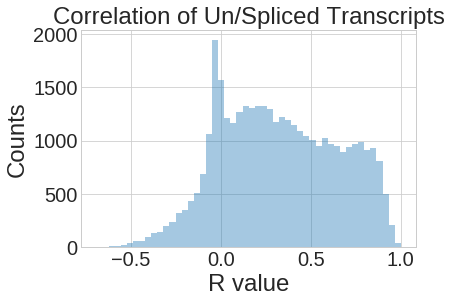

In [27]:
pair = [i[:-3] for i in df.loc[~spliced].index.values]
paired_data = zip(df.loc[~spliced].values, df.loc[pair].values)

r_vals = np.array([pearsonr(un_row, row)[0] for un_row, row in paired_data])
print(r_vals[:5])
r_vals = r_vals[~np.isnan(r_vals)]
print(r_vals[:5])
sns.distplot(r_vals, kde=False)
plt.title('Correlation of Un/Spliced Transcripts')
plt.xlabel('R value')
plt.ylabel('Counts')
plt.show()

In [28]:
print(describe(r_vals))
np.count_nonzero(r_vals)

DescribeResult(nobs=37030, minmax=(-0.69234553214112227, 1.0), mean=0.32212883144461674, variance=0.10616089341037895, skewness=0.032039127773380666, kurtosis=-0.8513156167434333)


37030

This is switching away from pairs, but it would be good to know what the expression range is for the RNAs.

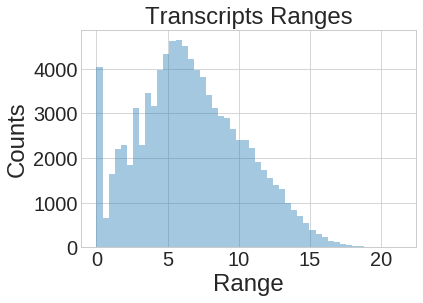

In [29]:
df_range = df.max(axis=1) - df.min(axis=1)
sns.distplot(df_range, kde=0)
plt.title('Transcripts Ranges')
plt.xlabel('Range')
plt.ylabel('Counts')
plt.show()

/home/jessime/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


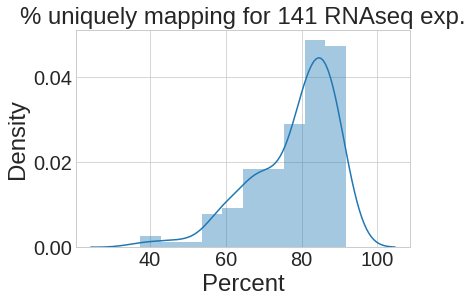

In [105]:
map_percent = []
with open('/home/jessime/Desktop/stats.txt') as infile:
    for line in infile:
        map_percent.append(float(line.split()[-1].strip('%')))
        
sns.distplot(map_percent)
plt.title('% uniquely mapping for 141 RNAseq exp.')
plt.ylabel('Density')
plt.xlabel('Percent')
plt.show()

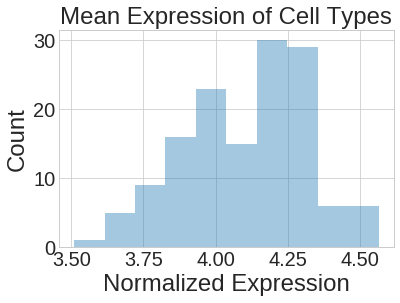

In [30]:
sns.distplot(df.mean(), kde=False)
plt.title('Mean Expression of Cell Types')
plt.ylabel('Count')
plt.xlabel('Normalized Expression')
plt.show()

In [109]:
print(2**4.5)
print(2**5.5)

22.627416997969522
45.254833995939045


Example of future correlations

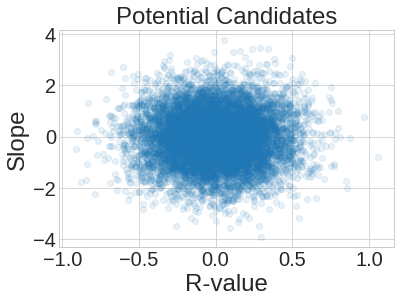

In [117]:
slope = np.random.normal(size=10000)
rand_r = np.random.normal(size=10000, scale=.25)

plt.scatter(rand_r, slope, alpha=.1)
plt.title('Potential Candidates')
plt.ylabel('Slope')
plt.xlabel('R-value')
plt.show()

## Nearby

I've done this before, but it's been a little bit. The question is, for each transcript, what are its set of nearby transcripts? 

In [7]:
%aimport gtf

In [162]:
chr_sizes = '/home/jessime/Desktop/hg38.chrom.sizes.txt'

with open(chr_sizes) as chr_sizes:
    chr_dict = {} 
    for l in chr_sizes.readlines():
        name, size = l.strip().split()
        chr_dict[name] = int(size)
    
chr_sizes = '/home/jessime/Research/hg38_chr_size.pkl'
pickle.dump(chr_dict, open(chr_sizes, 'wb'))

In [8]:
inGTF = '/home/jessime/Research/v26_full_unspliced.gtf'
chr_sizes = '/home/jessime/Research/hg38_chr_size.pkl'

expanded = gtf.Maker(inGTF)
expanded.expand_transcripts()
expanded.inGTF = expanded.expandedDF
expanded = expanded.expand_regions(100000, chr_sizes)
print(expanded.shape)

(234537, 30)


In [18]:
extracter = gtf.Extracter()
extracter.inGTF = expanded
lookup = extracter.intersection_lookup(inGTF)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [19]:
len(lookup)

234213

In [27]:
lookup['XIST-001']

{'ENSG00000182707.4',
 'ENSG00000225470.7',
 'ENSG00000228906.1',
 'ENSG00000229807.10',
 'ENSG00000230146.1',
 'ENSG00000230590.8',
 'ENSG00000270641.1',
 'ENSG00000274430.1',
 'ENSG00000274655.1',
 'ENSG00000276784.1',
 'ENSG00000277577.1',
 'ENSG00000278039.1'}

In [71]:
nearby_tx = '/home/jessime/Research/encode_rnaseq/nearby100k_transcripts.pkl'
pickle.dump(dict(lookup), open(nearby_tx, 'wb'))

At this point, I've saved a dictionary where all transcripts in my `v26_full_unspliced.gtf` file have a key, and their value is a set of all GENES (note that keys are transcripts and values are sets of GENES) within 100k of the start and end of the transcript of interest. 

Going forward, we can think of the keys as potential repressors and the values as potential targets. I will have to do more name conversion along the way though.

Just as a check, let's see the distribution of number of genes in these target sets.

In [33]:
sns.distplot([len(v) for v in lookup.values()])
plt.title('Potential targets per transcript')
plt.show()

And how many correlations are we going to have?

In [34]:
sum(len(v) for v in lookup.values())

2358195

## Correlations

Let's load up the matrix (and name conversions) and do a practice correlation.

In [28]:
df = '/home/jessime/Research/encode_rnaseq/salmon_norm_counts.csv'
df = pd.read_csv(df, index_col=0)
df.tail()

1          2          3          4          5          6  \
ZYXP1      0.755728   0.755728   0.755728   0.755728   0.755728   0.755728   
ZZEF1     12.501104  12.964530  12.351837  12.203864  12.494895  12.734652   
ZZEF1-un  11.623556  11.699971  11.120169  11.350342  11.297797  11.518564   
ZZZ3      12.155220  12.693151  12.573226  12.773586  12.753904  12.561719   
ZZZ3-un   12.623381  13.178491  12.439274  12.867412  12.539662  12.766681   

                  7          8          9         10    ...            131  \
ZYXP1      0.755728   0.755728   0.755728   0.755728    ...       0.755728   
ZZEF1     12.531573  12.795798  13.193828  13.057588    ...      10.498774   
ZZEF1-un  11.329642  11.119786  11.441969  11.277670    ...      10.443358   
ZZZ3      12.571604  12.694930  12.670994  13.099953    ...      11.976845   
ZZZ3-un   12.181663  12.481083  12.864670  12.332457    ...      12.459915   

                132        133        134        135        136        137  \
ZYXP1      0.755728   0.755728   0.755728   0.755728   0.755728   0.755728   
ZZEF1     12.594611  13.762493  13.587867  11.733402  12.249892  12.499583   
ZZEF1-un  11.985084  11.698411  10.045233   8.982150  10.670177  11.566949   
ZZZ3      11.689081  11.083325  12.976500  12.387358  12.108409  12.203623   
ZZZ3-un   13.104973  11.256418  11.164110   9.912005  13.407279  11.995392   

                138        139        140  
ZYXP1      0.755728   0.755728   0.755728  
ZZEF1     11.832354  12.020237  13.421144  
ZZEF1-un  10.794404  10.336886  11.379476  
ZZZ3      12.249837  12.395320  10.995752  
ZZZ3-un   12.506516  10.434956  10.960090  

[5 rows x 140 columns]

I also need to make and save a gene level expression matrix

In [29]:
df_genes = df.copy()
df_genes.index = [i.strip('-un') for i in df.index.values]
print(df_genes.shape)
df_genes = df_genes.groupby(level=0).sum()

outfile = '/home/jessime/Research/encode_rnaseq/salmon_gene_counts.csv'
df_genes.to_csv(outfile)
print(df_genes.shape)
df_genes.tail()

(93228, 140)
(58094, 140)


1         2         3         4         5         6  \
snoZ6.2     0.755728  0.755728  0.755728  0.755728  0.755728  0.755728   
snoZ6.3     0.755728  0.755728  0.755728  0.755728  0.755728  0.755728   
snoZ6.4     0.755728  0.755728  0.755728  0.755728  0.755728  0.755728   
snosnR66.1  0.755728  0.755728  0.755728  0.755728  0.755728  0.755728   
yR211F11.2  3.092671  1.511456  1.511456  3.022410  2.235819  2.401799   

                   7         8         9        10    ...          131  \
snoZ6.2     0.755728  0.755728  0.755728  0.755728    ...     0.755728   
snoZ6.3     0.755728  0.755728  0.755728  0.755728    ...     0.755728   
snoZ6.4     0.755728  0.755728  0.755728  0.755728    ...     0.755728   
snosnR66.1  0.755728  0.755728  0.755728  0.755728    ...     0.755728   
yR211F11.2  1.511456  2.434604  1.511456  2.173769    ...     1.511456   

                 132       133       134       135       136       137  \
snoZ6.2     0.755728  0.755728  0.755728  0.755728  0.755728  0.755728   
snoZ6.3     0.755728  0.755728  0.755728  0.755728  0.755728  0.755728   
snoZ6.4     0.755728  0.755728  0.755728  0.755728  0.755728  0.755728   
snosnR66.1  0.755728  0.755728  0.755728  0.755728  0.755728  0.755728   
yR211F11.2  2.302017  1.511456  2.486074  4.038334  3.054033  2.541220   

                 138       139       140  
snoZ6.2     0.755728  0.755728  0.755728  
snoZ6.3     0.755728  0.755728  0.755728  
snoZ6.4     0.755728  0.755728  0.755728  
snosnR66.1  0.755728  0.755728  0.755728  
yR211F11.2  2.901524  2.678431  1.511456  

[5 rows x 140 columns]

In [30]:
id2name = '/home/jessime/Research/v26_full_unspliced_id2name.csv'
id2name = pd.read_csv(id2name, index_col=0)
id2name.head()

Unnamed: 0.1            gene_id       common  spliced
0         UNSPLICED0  ENSG00000223972.5   DDX11L1-un    False
1  ENST00000456328.2  ENSG00000223972.5  DDX11L1-002     True
2  ENST00000450305.2  ENSG00000223972.5  DDX11L1-001     True
3         UNSPLICED1  ENSG00000227232.5    WASH7P-un    False
4  ENST00000488147.1  ENSG00000227232.5   WASH7P-001     True

I need to convert these gene_id values to common gene names found in my salmon counts df. 

In [31]:
cols = zip(id2name['gene_id'].values, id2name['common'].values)
gene_id2gene = {gid: c[:c.rindex('-')] for gid, c in cols}
print(gene_id2gene['ENSG00000223972.5'])
print(gene_id2gene['ENSG00000227232.5'])

DDX11L1
WASH7P


Before this turns into a nightmare of dictionaries, I just need to make it into a dataframe.

The index will be numeric and columns will be:

1. repressor : Identified by salmon transcript name
2. target : Identified by salmon gene name
3. r_value : Calculated as the correlation between the repressor and the target
4. slope: The slope of the line of best fit

In [32]:
nearby_tx = '/home/jessime/Research/encode_rnaseq/nearby100k_transcripts.pkl'
nearby_tx = pickle.load(open(nearby_tx, 'rb'))

In [33]:
endings = list(set(i.split('-')[-1] for i in nearby_tx.keys() if '-un' not in i))
print(len(endings))

182


In [49]:
repressor = []
target = []

for i, r in enumerate(df.index):
    if r.endswith('-un'):
        r_target_set = nearby_tx[r]
                  
    else:
        #This is a stupid way of doing this.
        #But I've combined all the spliced isoforms by removing their transcript identifiers
        #So I'm going to go through all the keys to build up the set of all targets
        #They should be more or less the same for each one
        #But I don't want to pick a transcript identifier at random either
        r_target_set = set()
        for e in endings:
            key = f'{r}-{e}'
            if key in nearby_tx:
                r_target_set |= nearby_tx[key]
    r_ls = [r] * len(r_target_set)
    r_target_ls = [gene_id2gene[i] for i in list(r_target_set)]
    repressor += r_ls
    target += r_target_ls

r_vals_df = pd.DataFrame(list(zip(repressor, target)), columns=['repressor', 'target'])
print(r_vals_df.shape)
r_vals_df.head()

(929934, 2)


repressor        target
0  5_8S_rRNA.1      MLLT10P1
1  5_8S_rRNA.1   5_8S_rRNA.1
2  5_8S_rRNA.1  RP11-462H3.2
3  5_8S_rRNA.1        FRG1BP
4  5_8S_rRNA.2   5_8S_rRNA.2

And here's where we actually get to figure something out instead of just playing with names.

In [65]:
%timeit 'snoZ278.1' in df_genes.index

622 ns ± 4.65 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [66]:
%timeit df_genes.loc['snoZ278.1'].values

79.1 µs ± 542 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [67]:
def try_apply(row, func):
    r = df.loc[row['repressor']].values
    result = np.nan
    t = row['target']
    if t in df_genes.index:
        t = df_genes.loc[t].values
        result = pearsonr(r, t)[0] if func == 'pearsonr' else polyfit(r, t, 1)[1]
    return result

def try_pearson(row):
    return try_apply(row, 'pearsonr')

def try_slope(row):
    return try_apply(row, 'polyfit')

tqdm.pandas()

r_vals_df['r_value'] = r_vals_df.apply(try_pearson, axis=1)
r_vals_df['slope'] = r_vals_df.apply(try_slope, axis=1)

outfile = '/home/jessime/Research/encode_rnaseq/r_vals.csv'
r_vals_df.to_csv(outfile)
r_vals_df.head()

/home/jessime/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/jessime/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RankWarning: The fit may be poorly conditioned
  import sys


repressor        target  r_value      slope
0  5_8S_rRNA.1      MLLT10P1      NaN   1.340909
1  5_8S_rRNA.1   5_8S_rRNA.1      NaN   0.500000
2  5_8S_rRNA.1  RP11-462H3.2      NaN   2.023329
3  5_8S_rRNA.1        FRG1BP      NaN  10.609324
4  5_8S_rRNA.2   5_8S_rRNA.2      NaN   0.500000

In [72]:
r_vals_df.shape

(929934, 4)

In [68]:
# r_value = []
# slope = []

# errors = []

# for i, row in tqdm(r_vals_df.iterrows()):
#     r = df.loc[row['repressor']].values
#     try:
#         t = df_genes.loc[row['target']].values
#         r_value.append(pearsonr(r, t)[0])
#         slope.append(polyfit(r, t, 1)[1])
#     except KeyError:
#         errors.append(row['target'])
#         r_value.append(np.nan)
#         slope.append(np.nan)
    
# r_vals_df['r_value'] = r_value
# r_vals_df['slope'] = slope

# outfile = '/home/jessime/Research/encode_rnaseq/r_vals.csv'
# r_vals_df.to_csv(outfile)
# r_vals_df.head()

In [73]:
print(len(errors))
errors[:20]

43


['uc_338.32',
 'uc_338.32',
 'uc_338.13',
 'uc_338.13',
 'uc_338.24',
 'uc_338.24',
 'uc_338.24',
 'uc_338.24',
 'uc_338.24',
 'uc_338.13',
 'uc_338.13',
 'uc_338.13',
 'uc_338.13',
 'uc_338.28',
 'uc_338.28',
 'uc_338.28',
 'uc_338.19',
 'uc_338.2',
 'uc_338.2',
 'uc_338.31']

I'm not entirely sure what those errors are, but I'm fine moving on without them.

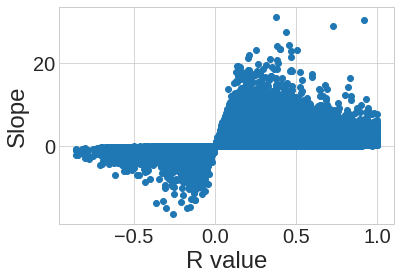

In [74]:
plt.scatter(r_vals_df['r_value'], r_vals_df['slope'])
plt.ylabel('Slope')
plt.xlabel('R value')
plt.show()

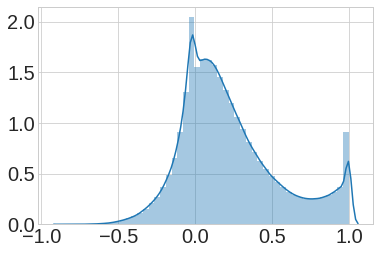

In [88]:
sns.distplot(r_vals_df['r_value'].dropna().values)

zoom in

In [78]:
plt.scatter(r_vals_df[r_vals_df['r_value'] < -.5]['r_value'], 
            r_vals_df[r_vals_df['r_value'] < -.5]['slope'],
            alpha=.5)
plt.ylabel('Slope')
plt.xlabel('R value')
plt.ylim([-7, -1])
plt.show()

In [79]:
r_vals_df.sort_values('r_value').dropna().head(10)

repressor      target   r_value     slope
110040       CCL17    CCDC102A -0.860969 -0.894489
110041       CCL17        DOK4 -0.860511 -0.996979
198888        DOK4       CCL17 -0.860157 -1.993386
272650  HIST2H2AA3      FCGR1A -0.860011 -0.711420
232006      FCGR1A  HIST2H2AA3 -0.851700 -1.367490
106206    CCDC102A       CCL17 -0.844373 -2.132550
110054    CCL17-un    CCDC102A -0.832259 -1.361951
104318  CASKIN2-un        GRB2 -0.821149 -0.583913
110055    CCL17-un        DOK4 -0.819259 -1.495086
104308     CASKIN2        GRB2 -0.804113 -0.513024

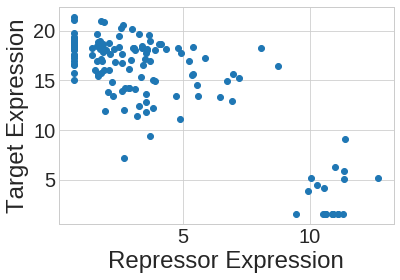

In [82]:
plt.scatter(df.loc['CCL17-un'], df_genes.loc['CCDC102A'])
plt.xlabel('Repressor Expression')
plt.ylabel('Target Expression')
plt.show()

In [80]:
plt.scatter(df.loc['CCL17'], df_genes.loc['CCDC102A'])
plt.xlabel('Repressor Expression')
plt.ylabel('Target Expression')
plt.show()

In [90]:
r_vals_best = r_vals_df[r_vals_df['r_value'] < -.5]
r_vals_best = r_vals_best[r_vals_best['slope'] < -.5]
r_vals_best = r_vals_best.dropna()
r_vals_best = r_vals_best.sort_values('r_value')
r_vals_best.shape

(1352, 4)

I don't want to store all of these, but I do want to visualize the scatter plots. So I'm going to make a folder on the desktop.

In [ ]:
!mkdir /home/jessime/Desktop/scatter2

In [86]:
c = 0
for i, row in r_vals_best.iterrows():
    plt.scatter(df.loc[row['repressor']], df_genes.loc[row['target']])
    plt.title(f"R: {row['r_value']:.2f} S: {row['slope']:.2f}")
    plt.xlabel(f"{row['repressor']} Expression")
    plt.ylabel(f"{row['target']} Expression")
    outfile = f'/home/jessime/Desktop/scatter2/{c}.png'
    plt.savefig(outfile, bbox_inches='tight')
    plt.clf()
    c += 1

In [91]:
r_vals_best.repressor.str.endswith('-un').sum()

544

Most of these are the spliced versions...

### Xist similarity

How similar are all of these top transcripts to Xist?

I'm not storing the full fasta file locally. So the way I'm going to handle this is by temporarily downloading the fasta. Find all xist likeness, and save that array, which I should have done anyway. It'll probably come in handy more than once. 

In [12]:
%aimport kmer_counts

In [7]:
!grep ">" /home/jessime/Research/v26_full_unspliced.fa > /home/jessime/Desktop/v26_headers.fa

In [8]:
headers = '/home/jessime/Desktop/v26_headers.fa'
with open(headers) as headers:
    headers = headers.readlines()
    
headers = [l.split()[0].strip('>') for l in headers]
headers[:5]

['ENST00000456328.2',
 'UNSPLICED0',
 'ENST00000450305.2',
 'ENST00000488147.1',
 'UNSPLICED1']

I'm more interested in keeping track of the common name though

In [9]:
id2name = '/home/jessime/Research/v26_full_unspliced_id2name.csv'
id2name = pd.read_csv(id2name)
id2name.head()

Unnamed: 0            gene_id       common  unspliced
0         UNSPLICED0  ENSG00000223972.5   DDX11L1-un       True
1  ENST00000456328.2  ENSG00000223972.5  DDX11L1-002      False
2  ENST00000450305.2  ENSG00000223972.5  DDX11L1-001      False
3         UNSPLICED1  ENSG00000227232.5    WASH7P-un       True
4  ENST00000488147.1  ENSG00000227232.5   WASH7P-001      False

In [10]:
id2name_dict = dict(zip(id2name['Unnamed: 0'], id2name['common']))

names = [id2name_dict[h] for h in headers]

In [13]:
infasta = '/home/jessime/Research/v26_full_unspliced.fa'

counter = kmer_counts.BasicCounter(infasta)
counter.get_counts()

Widget Javascript not detected.  It may not be installed or enabled properly.


In [18]:
mean = '/home/jessime/Research/fa_arrays/v26_6mer_mean.npy'
np.save(mean, counter.mean)

std = '/home/jessime/Research/fa_arrays/v26_6mers_std.npy'
np.save(std, counter.std)

In [19]:
counter.counts.shape

(234537, 4096)

In [20]:
names.index('XIST-001')

229474

In [22]:
%aimport pearson

In [27]:
xist = counter.counts[names.index('XIST-001')]
xist = xist.reshape([1, 4096])
#xist_sim = np.corrcoef(xist, counter.counts)
xist_sim = pearson.pearson(xist, counter.counts)
xist_sim.shape

(1, 234537)

In [31]:
xist_sim = pd.DataFrame(xist_sim[0], index=names, columns=['XIST-001'])
xist_sim.head()

XIST-001
DDX11L1-002 -0.033451
DDX11L1-un  -0.094976
DDX11L1-001 -0.111606
WASH7P-001  -0.145943
WASH7P-un   -0.053444

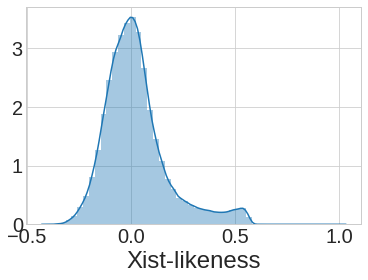

In [36]:
sns.distplot(xist_sim)
plt.xlabel('Xist-likeness');

In [32]:
xist_sim.loc['XIST-001']

XIST-001    1.0
Name: XIST-001, dtype: float32

I want to separate out spliced. But first, I'm going to resave this id2name csv, where I've switched spliced and unspliced.

In [38]:
id2name['spliced'] = ~id2name['unspliced']
del id2name['unspliced']
id2name.head()

Unnamed: 0            gene_id       common  spliced
0         UNSPLICED0  ENSG00000223972.5   DDX11L1-un    False
1  ENST00000456328.2  ENSG00000223972.5  DDX11L1-002     True
2  ENST00000450305.2  ENSG00000223972.5  DDX11L1-001     True
3         UNSPLICED1  ENSG00000227232.5    WASH7P-un    False
4  ENST00000488147.1  ENSG00000227232.5   WASH7P-001     True

In [39]:
outfile = '/home/jessime/Research/v26_full_unspliced_id2name.csv'
id2name.to_csv(outfile)

In [41]:
spliced_set = set(id2name[id2name['spliced']]['common'].values)
len(spliced_set)

176089

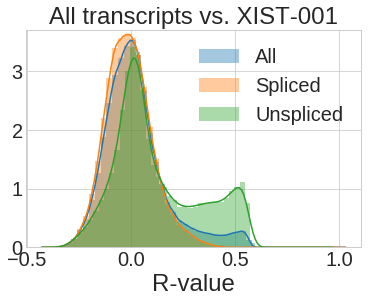

In [45]:
sns.distplot(xist_sim, label='All')
sns.distplot(xist_sim[xist_sim.index.isin(spliced_set)], label='Spliced')
sns.distplot(xist_sim[~xist_sim.index.isin(spliced_set)], label='Unspliced')
plt.legend()
plt.title('All transcripts vs. XIST-001')
plt.xlabel('R-value');

That's so crazy.

In [46]:
outfile = '/home/jessime/Research/v26_full_unspliced_XIST_R.csv'
xist_sim.to_csv(outfile)

So what does the distribution of the top potential repressors look like?

In [9]:
xist_sim = '/home/jessime/Research/v26_full_unspliced_XIST_R.csv'
xist_sim = pd.read_csv(xist_sim, index_col=0)

In [7]:
r_vals_df = '/home/jessime/Research/encode_rnaseq/r_vals.csv'
r_vals_df = pd.read_csv(r_vals_df, index_col=0)
r_vals_df.head()

repressor          target   r_value     slope
0  A1BG-AS1-un          ZNF544  0.126906  0.147461
1  A1BG-AS1-un         MIR4754 -0.025857 -0.003239
2  A1BG-AS1-un  CTD-2619J13.14  0.176860  0.167421
3  A1BG-AS1-un          ZNF584  0.189763  0.128796
4  A1BG-AS1-un  CTD-2619J13.19  0.215819  0.111697

Right now, I'm only interested in the potential repressors, but down the road, there's a good chance that I'm going to want this information for other `r_vals_df` rows as well, so I might as well do them all at once. 

In [8]:
r_vals_best = r_vals_df[r_vals_df['r_value'] < -.5]
r_vals_best = r_vals_best[r_vals_best['slope'] < -.5]
r_vals_best = r_vals_best.dropna()
r_vals_best = r_vals_best.sort_values('r_value')
r_vals_best.shape

(544, 4)

In [10]:
best_xist_sims = xist_sim[xist_sim.index.isin(r_vals_best['repressor'].values)]
print(best_xist_sims.shape)
best_xist_sims.head()

(465, 1)


XIST-001
RP5-857K21.4-un  0.466965
LINC01786-un    -0.012141
KIF1B-un         0.394454
DFFA-un         -0.016104
FLJ37453-un     -0.063908

This discrepency is fine since a repressor can show up more than once. This is another aside, but check this out:

In [13]:
r_vals_best[r_vals_best['repressor'] == 'PCDHGC5-un']

repressor    target   r_value     slope
193341  PCDHGC5-un   PCDHGB1 -0.637609 -1.828641
193357  PCDHGC5-un   PCDHGA9 -0.599725 -0.727033
193338  PCDHGC5-un   PCDHGA1 -0.584658 -1.459596
193364  PCDHGC5-un   PCDHGB6 -0.578887 -0.808568
193342  PCDHGC5-un   PCDHGB4 -0.569051 -1.244495
193362  PCDHGC5-un  PCDHGA12 -0.559534 -0.890326
193352  PCDHGC5-un  PCDHGB8P -0.555925 -0.632131
193363  PCDHGC5-un   PCDHGB7 -0.547379 -0.912425
193355  PCDHGC5-un  PCDHGA11 -0.545071 -0.850041
193356  PCDHGC5-un  PCDHGA10 -0.530101 -0.776562
193344  PCDHGC5-un   PCDHGA2 -0.525477 -1.361824
193345  PCDHGC5-un   PCDHGC3 -0.509654 -1.052155
193360  PCDHGC5-un   PCDHGA6 -0.506871 -0.668642

In [19]:
r_vals_xist = r_vals_best.set_index('repressor')
r_vals_xist = r_vals_xist.join(best_xist_sims)
print(r_vals_xist.shape)
r_vals_xist.sort_values('XIST-001').tail(10)

(544, 4)


target   r_value     slope  XIST-001
RP11-21J18.1-un    NDUFV2-AS1 -0.683762 -0.671151  0.531083
DTWD2-un            MIR1244-2 -0.553687 -1.154845  0.536474
DCAF6-un               GCSHP5 -0.528479 -0.775955  0.537068
HDAC8-un                RPS4X -0.589285 -0.927664  0.538678
RAB3GAP2-un         MORF4L1P1 -0.561214 -0.909820  0.539646
BTBD9-un                 GLO1 -0.509306 -0.609220  0.543593
THSD4-un            THSD4-AS1 -0.507237 -0.594069  0.556186
PIGK-un          RP4-706A16.3 -0.599148 -1.155429  0.557271
OMA1-un                  DAB1 -0.502701 -0.943739  0.567747
SND1-un                  ARF5 -0.536315 -0.913576  0.575378

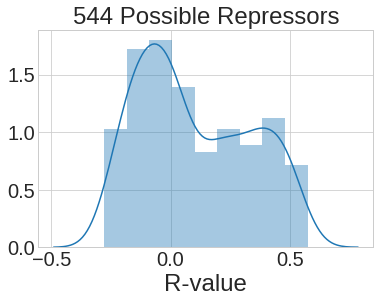

In [20]:
sns.distplot(r_vals_xist['XIST-001'])
plt.xlabel('R-value')
plt.title('544 Possible Repressors');

We've used .13 as a cutoff for similarity before. What if we use it here?

In [21]:
r_vals_xist[r_vals_xist['XIST-001'] > .13].shape

(227, 4)

In [22]:
r_vals_xist[r_vals_xist['XIST-001'] > .13*2].shape

(162, 4)

So a decent number a quite XIST like. That's great. I also want to know what the correlation pairs are of their spliced version.